In [1]:
!wget http://ipa.lovethosetrains.com/ipa_17_18.7z

--2020-02-14 20:43:27--  http://ipa.lovethosetrains.com/ipa_17_18.7z
Resolving ipa.lovethosetrains.com... 51.255.167.155
Connecting to ipa.lovethosetrains.com|51.255.167.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152896489 (146M) [application/x-7z-compressed]
Saving to: 'ipa_17_18.7z.1'

ipa_17_18.7z.1      100%[===================>] 145.81M  3.29MB/s    in 63s     

2020-02-14 20:44:30 (2.33 MB/s) - 'ipa_17_18.7z.1' saved [152896489/152896489]



In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("local") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext

In [4]:
import json
sample_train = json.load(open("data/60745", 'r'))

In [5]:
sample_train

{'schedules': [{'info': [{'arrival_delay': None,
     'arrival_time': None,
     'departure_delay': 0,
     'departure_time': '2018-12-08T17:00:00',
     'station_name': 'Zawadzkie'},
    {'arrival_delay': 0,
     'arrival_time': '2018-12-08T17:08:42',
     'departure_delay': 0,
     'departure_time': '2018-12-08T17:09:00',
     'station_name': 'Kolonowskie'},
    {'arrival_delay': 0,
     'arrival_time': '2018-12-08T17:12:00',
     'departure_delay': 0,
     'departure_time': '2018-12-08T17:18:00',
     'station_name': 'Fosowskie'},
    {'arrival_delay': 0,
     'arrival_time': '2018-12-08T17:21:12',
     'departure_delay': 0,
     'departure_time': '2018-12-08T17:21:30',
     'station_name': 'Staniszcze Małe'},
    {'arrival_delay': 0,
     'arrival_time': '2018-12-08T17:25:42',
     'departure_delay': 0,
     'departure_time': '2018-12-08T17:26:00',
     'station_name': 'Krasiejów'},
    {'arrival_delay': 0,
     'arrival_time': '2018-12-08T17:28:42',
     'departure_delay': 0,
    

In [6]:
DF = spark.read.json("data/*")

In [7]:
SAMPLE = DF.sample(True, 0.1).limit(10).cache()

In [8]:
SAMPLE.printSchema()

root
 |-- schedules: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- info: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- arrival_delay: long (nullable = true)
 |    |    |    |    |-- arrival_time: string (nullable = true)
 |    |    |    |    |-- departure_delay: long (nullable = true)
 |    |    |    |    |-- departure_time: string (nullable = true)
 |    |    |    |    |-- station_name: string (nullable = true)
 |    |    |-- schedule_date: string (nullable = true)
 |    |    |-- schedule_id: long (nullable = true)
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)



### docs
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.explode


In [9]:
from pyspark.sql.functions import explode

In [10]:
SAMPLE.select("train_id", "train_name", explode(SAMPLE.schedules).alias('schedules')) \
    .printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedules: struct (nullable = true)
 |    |-- info: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- arrival_delay: long (nullable = true)
 |    |    |    |-- arrival_time: string (nullable = true)
 |    |    |    |-- departure_delay: long (nullable = true)
 |    |    |    |-- departure_time: string (nullable = true)
 |    |    |    |-- station_name: string (nullable = true)
 |    |-- schedule_date: string (nullable = true)
 |    |-- schedule_id: long (nullable = true)



In [11]:
from pyspark.sql.functions import col

MODEL = SAMPLE.select("train_id", "train_name", explode(SAMPLE.schedules).alias("schedules")) \
    .select("train_id", "train_name", "schedules.schedule_date", "schedules.schedule_id", explode("schedules.info").alias("info")) \
    .select(
        "train_id",
        "train_name",
        col("`schedules.schedule_date`").cast("timestamp").alias("schedule_date"),
        col("`schedules.schedule_id`").alias("schedule_id"),
        "info.*"
    ) \
    .select(
        "train_id",
        "train_name",
        "schedule_date",
        "schedule_id",
        "arrival_delay",
        col("arrival_time").cast("timestamp"),
        "departure_delay",
        col("departure_time").cast("timestamp"),
        "station_name"
    )
    

In [12]:
MODEL.printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [13]:
!rm -r trains_sample.parquet

In [14]:
!apk add libc6-compat

7  0%                                                                           8OK: 1882 MiB in 291 packages


In [20]:
MODEL.printSchema();

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [21]:
MODEL.cache()

DataFrame[train_id: bigint, train_name: string, schedule_date: timestamp, schedule_id: bigint, arrival_delay: bigint, arrival_time: timestamp, departure_delay: bigint, departure_time: timestamp, station_name: string]

In [24]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
MODEL.registerTempTable("trains")

In [28]:
sqlContext.sql("""
    Select * from trains LIMIT 5
""").show()

+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|train_id|        train_name|      schedule_date|schedule_id|arrival_delay|       arrival_time|departure_delay|     departure_time|        station_name|
+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|         null|               null|              0|2018-12-08 13:17:00|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12-08 13:21:00|              0|2018-12-08 13:21:30|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12-08 13:27:00|              0|2018-12-08 13:27:30|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12

In [66]:
sqlContext.sql("""
    Select max(arrival_delay), min(arrival_delay) max_delay from trains LIMIT 5
""").show()

+------------------+---------+
|max(arrival_delay)|max_delay|
+------------------+---------+
|               217|       -6|
+------------------+---------+



In [36]:
sqlContext.sql("""
    Select train_name, station_name, (arrival_delay - departure_delay) from trains
    WHERE (arrival_delay - departure_delay) > 0
    LIMIT 5
""").show()

+------------------+--------------------+---------------------------------+
|        train_name|        station_name|(arrival_delay - departure_delay)|
+------------------+--------------------+---------------------------------+
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                1|
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                2|
|67900/1 KAMIEŃCZYK|      Wrocław Główny|                                8|
+------------------+--------------------+---------------------------------+



In [65]:
sqlContext.sql("""
    Select train_name, station_name, (arrival_delay - departure_delay) from trains
    WHERE (arrival_delay - departure_delay) > 0
    LIMIT 5
""").show()

+------------------+--------------------+---------------------------------+
|        train_name|        station_name|(arrival_delay - departure_delay)|
+------------------+--------------------+---------------------------------+
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                1|
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                2|
|67900/1 KAMIEŃCZYK|      Wrocław Główny|                                8|
+------------------+--------------------+---------------------------------+



In [15]:
#MODEL.write.parquet("trains_sample.parquet")

Py4JJavaError: An error occurred while calling o94.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:81)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:229)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:566)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 9880, localhost, executor driver): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.UnsatisfiedLinkError: /tmp/snappy-1.1.7-b503d27e-6383-4c1b-98f0-430d04722ff9-libsnappyjava.so: Error loading shared library ld-linux-x86-64.so.2: No such file or directory (needed by /tmp/snappy-1.1.7-b503d27e-6383-4c1b-98f0-430d04722ff9-libsnappyjava.so)
	at java.lang.ClassLoader$NativeLibrary.load(Native Method)
	at java.lang.ClassLoader.loadLibrary0(ClassLoader.java:1946)
	at java.lang.ClassLoader.loadLibrary(ClassLoader.java:1828)
	at java.lang.Runtime.load0(Runtime.java:810)
	at java.lang.System.load(System.java:1088)
	at org.xerial.snappy.SnappyLoader.loadNativeLibrary(SnappyLoader.java:179)
	at org.xerial.snappy.SnappyLoader.loadSnappyApi(SnappyLoader.java:154)
	at org.xerial.snappy.Snappy.<clinit>(Snappy.java:47)
	at org.apache.parquet.hadoop.codec.SnappyCompressor.compress(SnappyCompressor.java:67)
	at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
	at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
	at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:165)
	at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:95)
	at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:147)
	at org.apache.parquet.column.impl.ColumnWriterV1.accountForValueWritten(ColumnWriterV1.java:106)
	at org.apache.parquet.column.impl.ColumnWriterV1.write(ColumnWriterV1.java:200)
	at org.apache.parquet.io.MessageColumnIO$MessageColumnIORecordConsumer.addBinary(MessageColumnIO.java:469)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$makeWriter$8.apply(ParquetWriteSupport.scala:163)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$makeWriter$8.apply(ParquetWriteSupport.scala:162)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$writeFields$1.apply$mcV$sp(ParquetWriteSupport.scala:124)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$consumeField(ParquetWriteSupport.scala:435)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$writeFields(ParquetWriteSupport.scala:123)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$write$1.apply$mcV$sp(ParquetWriteSupport.scala:114)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.consumeMessage(ParquetWriteSupport.scala:423)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.write(ParquetWriteSupport.scala:113)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.write(ParquetWriteSupport.scala:50)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.write(InternalParquetRecordWriter.java:128)
	at org.apache.parquet.hadoop.ParquetRecordWriter.write(ParquetRecordWriter.java:182)
	at org.apache.parquet.hadoop.ParquetRecordWriter.write(ParquetRecordWriter.java:44)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.write(ParquetOutputWriter.scala:40)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.write(FileFormatDataWriter.scala:137)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:245)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1394)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more
	Suppressed: java.lang.NoClassDefFoundError: Could not initialize class org.xerial.snappy.Snappy
		at org.apache.parquet.hadoop.codec.SnappyCompressor.compress(SnappyCompressor.java:67)
		at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
		at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
		at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:165)
		at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:95)
		at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:147)
		at org.apache.parquet.column.impl.ColumnWriterV1.flush(ColumnWriterV1.java:235)
		at org.apache.parquet.column.impl.ColumnWriteStoreV1.flush(ColumnWriteStoreV1.java:122)
		at org.apache.parquet.hadoop.InternalParquetRecordWriter.flushRowGroupToStore(InternalParquetRecordWriter.java:172)
		at org.apache.parquet.hadoop.InternalParquetRecordWriter.close(InternalParquetRecordWriter.java:114)
		at org.apache.parquet.hadoop.ParquetRecordWriter.close(ParquetRecordWriter.java:165)
		at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.close(ParquetOutputWriter.scala:42)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.releaseResources(FileFormatDataWriter.scala:57)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.abort(FileFormatDataWriter.scala:83)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$1.apply$mcV$sp(FileFormatWriter.scala:250)
		at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1403)
		... 11 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:167)
	... 33 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.UnsatisfiedLinkError: /tmp/snappy-1.1.7-b503d27e-6383-4c1b-98f0-430d04722ff9-libsnappyjava.so: Error loading shared library ld-linux-x86-64.so.2: No such file or directory (needed by /tmp/snappy-1.1.7-b503d27e-6383-4c1b-98f0-430d04722ff9-libsnappyjava.so)
	at java.lang.ClassLoader$NativeLibrary.load(Native Method)
	at java.lang.ClassLoader.loadLibrary0(ClassLoader.java:1946)
	at java.lang.ClassLoader.loadLibrary(ClassLoader.java:1828)
	at java.lang.Runtime.load0(Runtime.java:810)
	at java.lang.System.load(System.java:1088)
	at org.xerial.snappy.SnappyLoader.loadNativeLibrary(SnappyLoader.java:179)
	at org.xerial.snappy.SnappyLoader.loadSnappyApi(SnappyLoader.java:154)
	at org.xerial.snappy.Snappy.<clinit>(Snappy.java:47)
	at org.apache.parquet.hadoop.codec.SnappyCompressor.compress(SnappyCompressor.java:67)
	at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
	at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
	at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:165)
	at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:95)
	at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:147)
	at org.apache.parquet.column.impl.ColumnWriterV1.accountForValueWritten(ColumnWriterV1.java:106)
	at org.apache.parquet.column.impl.ColumnWriterV1.write(ColumnWriterV1.java:200)
	at org.apache.parquet.io.MessageColumnIO$MessageColumnIORecordConsumer.addBinary(MessageColumnIO.java:469)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$makeWriter$8.apply(ParquetWriteSupport.scala:163)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$makeWriter$8.apply(ParquetWriteSupport.scala:162)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$writeFields$1.apply$mcV$sp(ParquetWriteSupport.scala:124)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$consumeField(ParquetWriteSupport.scala:435)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.org$apache$spark$sql$execution$datasources$parquet$ParquetWriteSupport$$writeFields(ParquetWriteSupport.scala:123)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport$$anonfun$write$1.apply$mcV$sp(ParquetWriteSupport.scala:114)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.consumeMessage(ParquetWriteSupport.scala:423)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.write(ParquetWriteSupport.scala:113)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.write(ParquetWriteSupport.scala:50)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.write(InternalParquetRecordWriter.java:128)
	at org.apache.parquet.hadoop.ParquetRecordWriter.write(ParquetRecordWriter.java:182)
	at org.apache.parquet.hadoop.ParquetRecordWriter.write(ParquetRecordWriter.java:44)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.write(ParquetOutputWriter.scala:40)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.write(FileFormatDataWriter.scala:137)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:245)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1394)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more
	Suppressed: java.lang.NoClassDefFoundError: Could not initialize class org.xerial.snappy.Snappy
		at org.apache.parquet.hadoop.codec.SnappyCompressor.compress(SnappyCompressor.java:67)
		at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
		at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
		at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:165)
		at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:95)
		at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:147)
		at org.apache.parquet.column.impl.ColumnWriterV1.flush(ColumnWriterV1.java:235)
		at org.apache.parquet.column.impl.ColumnWriteStoreV1.flush(ColumnWriteStoreV1.java:122)
		at org.apache.parquet.hadoop.InternalParquetRecordWriter.flushRowGroupToStore(InternalParquetRecordWriter.java:172)
		at org.apache.parquet.hadoop.InternalParquetRecordWriter.close(InternalParquetRecordWriter.java:114)
		at org.apache.parquet.hadoop.ParquetRecordWriter.close(ParquetRecordWriter.java:165)
		at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.close(ParquetOutputWriter.scala:42)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.releaseResources(FileFormatDataWriter.scala:57)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.abort(FileFormatDataWriter.scala:83)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$1.apply$mcV$sp(FileFormatWriter.scala:250)
		at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1403)
		... 11 more


* opóźnienia są różne, czasem jakieś całkowicie nierealne – na przykład -520 minut (tak, minus – pociąg przyjechał za wcześnie! Kilka godzin!)
* pociąg na danej stacji może mieć opóźniony przyjazd i opóźniony odjazd, może krócej stać na stacji i niwelować opóźnienie
* jedno jest pewne – na stacji początkowej nie ma wartości dla arrival_delay, a na stacji końcowej – nie ma departure_delay.


In [46]:
DELAYS = sqlContext.sql("""
    Select arrival_delay, count(train_id) as count from trains
    WHERE 
        arrival_delay IS NOT NULL
    GROUP BY arrival_delay
    ORDER BY arrival_delay ASC
    LIMIT 100
""")

In [47]:
DELAYS.show()

+-------------+-----+
|arrival_delay|count|
+-------------+-----+
|           -6|    5|
|           -5|    5|
|           -4|   28|
|           -3|   97|
|           -2|  607|
|           -1| 3552|
|            0|74121|
|            1|18384|
|            2|11509|
|            3| 7616|
|            4| 5646|
|            5| 4599|
|            6| 3496|
|            7| 3084|
|            8| 2511|
|            9| 2209|
|           10| 1754|
|           11| 1534|
|           12| 1484|
|           13| 1261|
+-------------+-----+
only showing top 20 rows



In [54]:
plot_data = DELAYS.toPandas()
plot_data.index = plot_data['count']

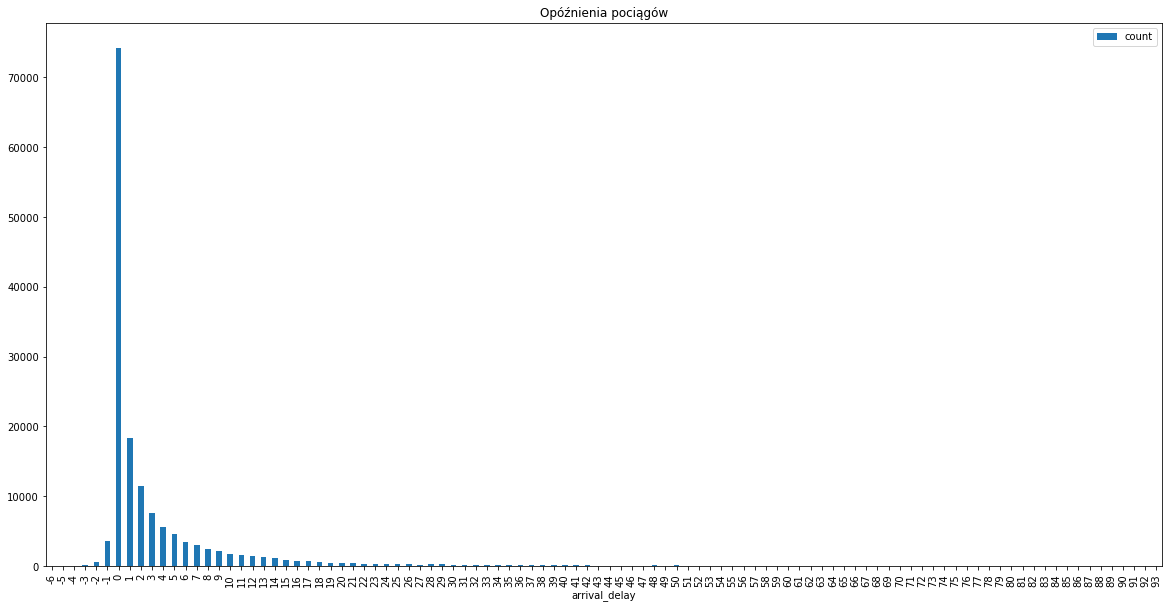

In [80]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

plot_data.plot(kind='bar', x='arrival_delay', title="Opóźnienia pociągów")

In [81]:
plot_data.describe()

,arrival_delay,count
count,100.000000,100.000000
mean,43.500000,1554.930000
std,29.011492,7715.919052
min,-6.000000,3.000000
25%,18.750000,42.750000
50%,43.500000,83.500000
75%,68.250000,333.750000
max,93.000000,74121.000000


In [82]:
MODEL.write.csv("trains_sample.csv")